# Preparacion de los datos

En este cuadernillo se van a extraer los datos de los dataset, se van atratar y se van a volver a guardar para ser usados en otros cuadernillos.

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
input_path = "Input/"
dataset_name = "cifar-10"

## Funciones

Funcion para extraer los datos de los ficheros

In [3]:
# https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin')
    return dict

Funcion Para el guardado de un set de datos

In [4]:
def saveDataset(dataset, name):
    savefile = input_path+dataset_name+"-"+name
    if os.path.isfile(savefile):
        print("Este set ya esta preparado")
    else:
        pickle.dump(dataset, open(savefile, "wb"))

Funcion para comprobar la correcta carga de un set de datos

In [5]:
def tryDataset(dataset):
    print(dataset["data"].shape)
    #plt.figure()
    f, arrx = plt.subplots(1,2)
    i = np.random.randint(0,dataset["data"].shape[0])
    arrx[0].imshow(dataset["data"][i])
    arrx[0].set_title(dataset["labels"][i])
    i = np.random.randint(0,dataset["data"].shape[0])
    arrx[1].imshow(dataset["data"][i])
    arrx[1].set_title(dataset["labels"][i])
    for a in arrx:
        a.axis("off")
    plt.show()
    plt.close()


## Carga y guardado

### Conjunto de entrenamiento

Extraemos los datos del fichero.

In [6]:
batch1 = unpickle("Input/cifar-10-batches-py/data_batch_1")
batch2 = unpickle("Input/cifar-10-batches-py/data_batch_2")
batch3 = unpickle("Input/cifar-10-batches-py/data_batch_3")
batch4 = unpickle("Input/cifar-10-batches-py/data_batch_4")
batch5 = unpickle("Input/cifar-10-batches-py/data_batch_5")

En cifar10 los datos estan almacenados en un diccionario que contiene el nombre del lote, las etiquetas para clasificacion, los datos (imagenes) y los nombres de fichero correspondientes.

In [7]:
print(batch1.keys())
for i in batch1:
    print(i, type(batch1[i]))

dict_keys(['batch_label', 'labels', 'data', 'filenames'])
batch_label <class 'str'>
labels <class 'list'>
data <class 'numpy.ndarray'>
filenames <class 'list'>


Las imagenes vienen en el modo ``channelsfirst``, en este modo, tenemos 3 matrices de la dimension de la imagen, una para cada canal. Muchas de las funciones admiten por defecto el modo ``chanelslast`` en el que tenemos una matriz de la dimension de la imagen y cada posicion tiene un vector con los codigos de color de cada punto.

Por simplicidad, como paso de preprocesamiento, voy a transformar las imagenes de ``channelsfirst`` a ``channelslast``.

In [8]:
# https://www.binarystudy.com/2021/09/how-to-load-preprocess-visualize-CIFAR-10-and-CIFAR-100.html
imagen = batch1["data"][0]
imagen = imagen.reshape(3,32,32)
imagen=imagen.transpose(1,2,0)
print(imagen.shape)

(32, 32, 3)


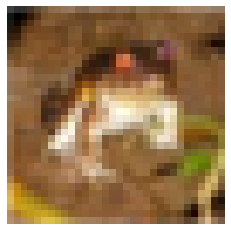

In [9]:
plt.imshow(imagen)
plt.axis("off")
del imagen

Cargamos todas las imagenes de entrenamiento en la variable ``X_train`` y borramos todo lo demás, excepto las etiquetas, ya que no lo vamos a utilizar.

In [10]:
print(batch1["data"].shape)
X_train = {}
X_train["data"] = batch1["data"].reshape(10000, 3, 32, 32)
X_train["labels"] = batch1["labels"]
del batch1
X_train["data"] = np.concatenate((X_train["data"], batch2["data"].reshape(10000, 3, 32, 32)))
X_train["labels"] = np.concatenate((X_train["labels"], batch2["labels"]))
del batch2
X_train["data"] = np.concatenate((X_train["data"], batch3["data"].reshape(10000, 3, 32, 32)))
X_train["labels"] = np.concatenate((X_train["labels"], batch3["labels"]))
del batch3
X_train["data"] = np.concatenate((X_train["data"], batch4["data"].reshape(10000, 3, 32, 32)))
X_train["labels"] = np.concatenate((X_train["labels"], batch4["labels"]))
del batch4
X_train["data"] = np.concatenate((X_train["data"], batch5["data"].reshape(10000, 3, 32, 32)))
X_train["labels"] = np.concatenate((X_train["labels"], batch5["labels"]))
del batch5
X_train["data"] = X_train["data"].transpose(0,2,3,1)
X_train["data"]=X_train["data"]/255

(10000, 3072)


Probamos el set de datos

(50000, 32, 32, 3)


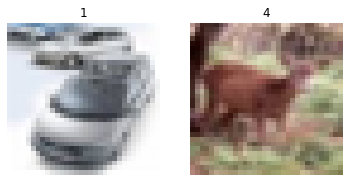

In [11]:
tryDataset(X_train)

Guardamos el set de datos en el almacenamiento y lo borramos de la memoria

In [12]:
saveDataset(X_train, "train")
del X_train

Volvemos a cargarlo en memoria para comprobar que se guarda correctamente

(50000, 32, 32, 3)


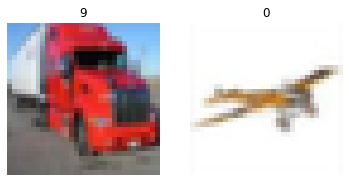

In [13]:
X_train = unpickle(input_path+dataset_name+"-train")
tryDataset(X_train)

### Conjunto de pruebas

Repetimos el mismo proceso para el conjunto de pruebas

(10000, 32, 32, 3)


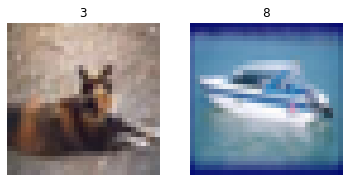

(10000, 32, 32, 3)


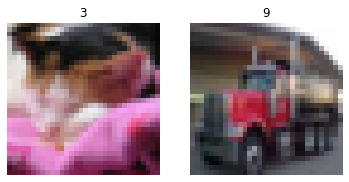

In [14]:
sample_from = unpickle("Input\cifar-10-batches-py\\test_batch")
X_test = {}
X_test["data"] = sample_from["data"].reshape(10000, 3, 32, 32)
X_test["labels"] = np.array(sample_from["labels"])
X_test["data"] = X_test["data"].transpose(0,2,3,1)
X_test["data"]=X_test["data"]/255
del sample_from
tryDataset(X_test)
saveDataset(X_test, "test")
X_test=unpickle(input_path+dataset_name+"-test")
tryDataset(X_test)

## Muestras de categorias

Este dataset va a contener imagenes agrupadas por clase de tal forma que al explorar mas tarde el espacio latente exploremos configuraciones cercanas a estas imagenes en lugar de puntos aleatorios, de esta forma se esperan obtener imagenes generadas de una coordenada distinta a las que se obtienen de las imagenes reales pero suficientemente cercanas como para que muestren caracteristicas propias de la categoria, demostrando asi que la red ha aprendido las caracteristicas de las imagenes.

In [15]:
def createGroupedPicDictionary(dataset, size, name, classes=[0,1,2,3,4,5,6,7,8,9]):
    dict={}
    labels = classes.copy()
    i=-1
    while(len(labels)>0):
        i+=1
        label= dataset["labels"][i]
        print("Label: ",label)
        if (label not in labels):
            continue
        if(label not in dict.keys()):
            dict[label] = []
        dict[label].append(dataset["data"][i])
        print("dict: ", dict.keys(), "Label", label, len(dict[label]))
        if (len(dict[label])>=size):
            dict[label] = np.array(dict[label])
            labels.remove(label)
            print("Labels: ", labels)
    saveDataset(dict, "grouped"+name)
    return dict

In [16]:
def showGroupedPicDictionary(dataset={}):
    rows = len(dataset.keys())
    columns = len(dataset[0])
    
    for label in dataset.keys():
        f, arrx = plt.subplots(1, columns)
        for i, img in enumerate(dataset[label]):
            
            arrx[i].imshow(img)
            arrx[i].set_title(label)
                
        for a in arrx:
            a.axis("off")
        plt.show()
        plt.close()
    

Label:  6
dict:  dict_keys([6]) Label 6 1
Label:  9
dict:  dict_keys([6, 9]) Label 9 1
Label:  9
dict:  dict_keys([6, 9]) Label 9 2
Labels:  [0, 1, 2, 3, 4, 5, 6, 7, 8]
Label:  4
dict:  dict_keys([6, 9, 4]) Label 4 1
Label:  1
dict:  dict_keys([6, 9, 4, 1]) Label 1 1
Label:  1
dict:  dict_keys([6, 9, 4, 1]) Label 1 2
Labels:  [0, 2, 3, 4, 5, 6, 7, 8]
Label:  2
dict:  dict_keys([6, 9, 4, 1, 2]) Label 2 1
Label:  7
dict:  dict_keys([6, 9, 4, 1, 2, 7]) Label 7 1
Label:  8
dict:  dict_keys([6, 9, 4, 1, 2, 7, 8]) Label 8 1
Label:  3
dict:  dict_keys([6, 9, 4, 1, 2, 7, 8, 3]) Label 3 1
Label:  4
dict:  dict_keys([6, 9, 4, 1, 2, 7, 8, 3]) Label 4 2
Labels:  [0, 2, 3, 5, 6, 7, 8]
Label:  7
dict:  dict_keys([6, 9, 4, 1, 2, 7, 8, 3]) Label 7 2
Labels:  [0, 2, 3, 5, 6, 8]
Label:  7
Label:  2
dict:  dict_keys([6, 9, 4, 1, 2, 7, 8, 3]) Label 2 2
Labels:  [0, 3, 5, 6, 8]
Label:  9
Label:  9
Label:  9
Label:  3
dict:  dict_keys([6, 9, 4, 1, 2, 7, 8, 3]) Label 3 2
Labels:  [0, 5, 6, 8]
Label:  2
Label

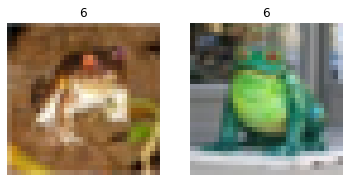

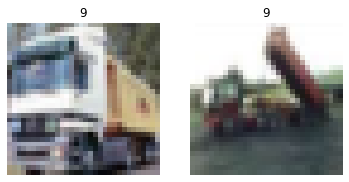

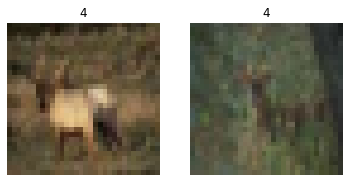

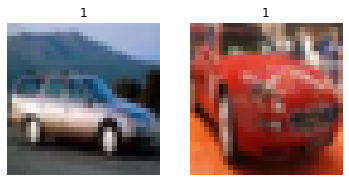

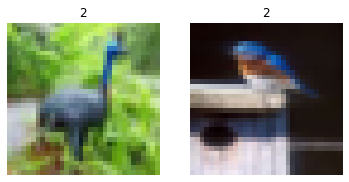

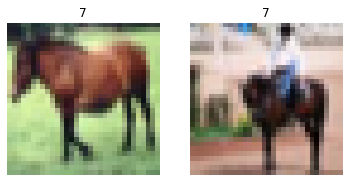

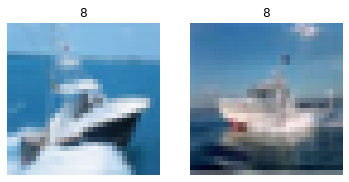

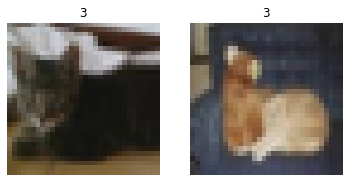

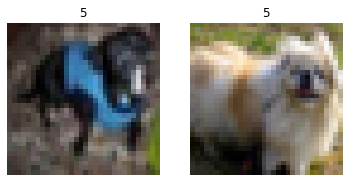

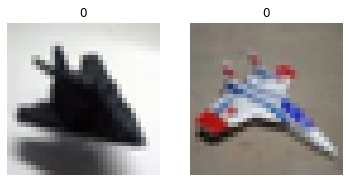

In [17]:
createGroupedPicDictionary(X_train, 2, "train")
groupedSample = unpickle(input_path+dataset_name+"-groupedtrain")
showGroupedPicDictionary(groupedSample)

Label:  3
dict:  dict_keys([3]) Label 3 1
Label:  8
dict:  dict_keys([3, 8]) Label 8 1
Label:  8
dict:  dict_keys([3, 8]) Label 8 2
Labels:  [0, 1, 2, 3, 4, 5, 6, 7, 9]
Label:  0
dict:  dict_keys([3, 8, 0]) Label 0 1
Label:  6
dict:  dict_keys([3, 8, 0, 6]) Label 6 1
Label:  6
dict:  dict_keys([3, 8, 0, 6]) Label 6 2
Labels:  [0, 1, 2, 3, 4, 5, 7, 9]
Label:  1
dict:  dict_keys([3, 8, 0, 6, 1]) Label 1 1
Label:  6
Label:  3
dict:  dict_keys([3, 8, 0, 6, 1]) Label 3 2
Labels:  [0, 1, 2, 4, 5, 7, 9]
Label:  1
dict:  dict_keys([3, 8, 0, 6, 1]) Label 1 2
Labels:  [0, 2, 4, 5, 7, 9]
Label:  0
dict:  dict_keys([3, 8, 0, 6, 1]) Label 0 2
Labels:  [2, 4, 5, 7, 9]
Label:  9
dict:  dict_keys([3, 8, 0, 6, 1, 9]) Label 9 1
Label:  5
dict:  dict_keys([3, 8, 0, 6, 1, 9, 5]) Label 5 1
Label:  7
dict:  dict_keys([3, 8, 0, 6, 1, 9, 5, 7]) Label 7 1
Label:  9
dict:  dict_keys([3, 8, 0, 6, 1, 9, 5, 7]) Label 9 2
Labels:  [2, 4, 5, 7]
Label:  8
Label:  5
dict:  dict_keys([3, 8, 0, 6, 1, 9, 5, 7]) Label 5 2

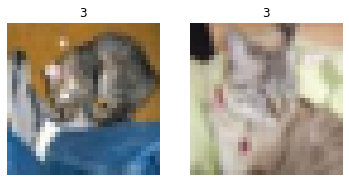

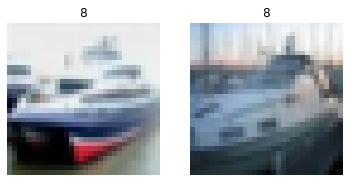

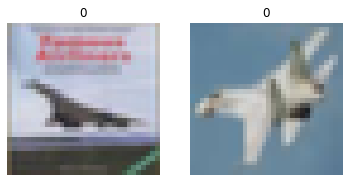

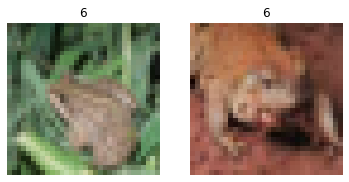

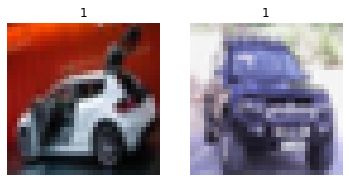

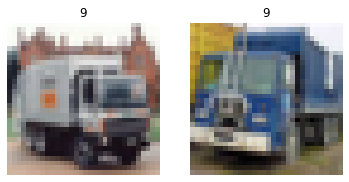

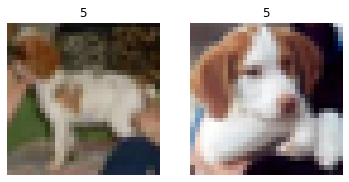

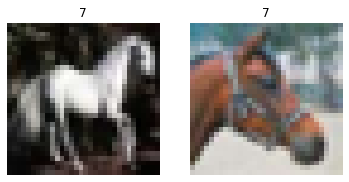

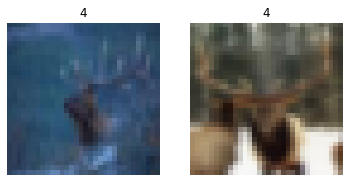

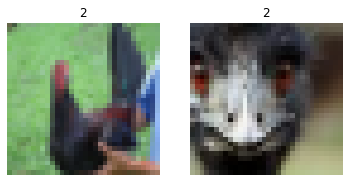

In [18]:
createGroupedPicDictionary(X_test, 2, "test")
groupedSample = unpickle(input_path+dataset_name+"-groupedtest")
showGroupedPicDictionary(groupedSample)

In [19]:
groupedSample

{3: array([[[[0.61960784, 0.43921569, 0.19215686],
          [0.62352941, 0.43529412, 0.18431373],
          [0.64705882, 0.45490196, 0.2       ],
          ...,
          [0.5372549 , 0.37254902, 0.14117647],
          [0.49411765, 0.35686275, 0.14117647],
          [0.45490196, 0.33333333, 0.12941176]],
 
         [[0.59607843, 0.43921569, 0.2       ],
          [0.59215686, 0.43137255, 0.15686275],
          [0.62352941, 0.44705882, 0.17647059],
          ...,
          [0.53333333, 0.37254902, 0.12156863],
          [0.49019608, 0.35686275, 0.1254902 ],
          [0.46666667, 0.34509804, 0.13333333]],
 
         [[0.59215686, 0.43137255, 0.18431373],
          [0.59215686, 0.42745098, 0.12941176],
          [0.61960784, 0.43529412, 0.14117647],
          ...,
          [0.54509804, 0.38431373, 0.13333333],
          [0.50980392, 0.37254902, 0.13333333],
          [0.47058824, 0.34901961, 0.12941176]],
 
         ...,
 
         [[0.26666667, 0.48627451, 0.69411765],
          [0.16